In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')

import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import os

2024-03-03 12:13:21.679472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/necessity_and_sufficiency/')

# Necessity

/tmp/ipykernel_3516505/324025515.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='context', y='Normalized shuffle effect', data=df,
/tmp/ipykernel_3516505/324025515.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='context', y='Normalized shuffle effect', data=df,
/tmp/ipykernel_3516505/324025515.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='context', y='Normalized shuffle effect', data=df,


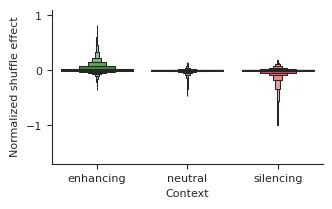

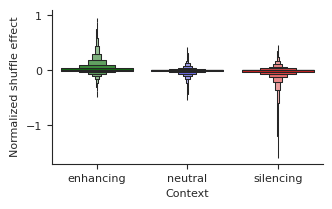

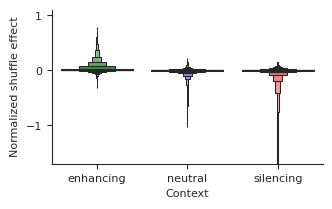

In [3]:
nec_result_summary = pd.read_csv('../results/summary_csvs/enformer/necessity_test.csv')
fontsize=8

#sns.set(font_scale = .9)
sns.set_style(style='white')
#plt.rcParams['xtick.major.size'] = 5
#plt.rcParams['xtick.major.width'] = 1

#plt.rcParams['ytick.major.size'] = 5
#plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True


for j, (cell, df) in enumerate(nec_result_summary.groupby('cell_line')):
    fig, ax = plt.subplots(1, 1, figsize=[3.5, 2])

    # ax = axes[j]
    N_per_context = {row['context']: f"{row['context']} N={row['count']}" for _, row in df['context'].value_counts().reset_index().iterrows()}

    my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
    sns.boxenplot(x='context', y='Normalized shuffle effect', data=df, 
                  showfliers=False,
#                   hue='context', 
                  ax=ax,
                  palette = my_pal
                 )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Context', fontsize=fontsize)
    ax.set_ylabel('Normalized shuffle effect', fontsize=fontsize)
    ax.set_ylim(-1.7,1.1)
    fig.savefig(f'{pdf_dir}/enformer_necessity_test_{cell}.pdf')

    #     handles, previous_labels = ax.get_legend_handles_labels()
#     ax.legend(handles=handles, labels=[N_per_context[l] for l in previous_labels], bbox_to_anchor=[1, 1])
#     ax.legend()

#     add number of observations in each box
#     medians = df.groupby(['context'])['Normalized shuffle effect'].median().values
#     nobs = df['context'].value_counts().values
#     nobs = [str(x) for x in nobs.tolist()]
#     nobs = ["n: " + i for i in nobs]

#     # Add it to the plot
#     pos = range(len(nobs))
#     for tick,label in zip(pos,ax.get_xticklabels()):
#         ax.text(pos[tick],
#                 medians[tick] - .7,
#                 nobs[tick],
#                 horizontalalignment='center',
#                 size='x-small',
#                 color='k',
#                 weight='semibold')
#     ax.set_title(cell)
#plt.tight_layout()

    

In [4]:
selected_cres = pd.read_csv('../results/summary_csvs/enformer/necessary_CREs.csv')

In [5]:
selected_cres.groupby(['cell_line', 'tile class', 'context']).count()

Unnamed: 0  Normalized shuffle effect  seq_id   
cell_line tile class context                                                    
GM12878   Enhancer   enhancing         147                        147     147  \
          Silencer   silencing          52                         52      52   
K562      Enhancer   enhancing         238                        238     238   
          Silencer   silencing         143                        143     143   
PC-3      Enhancer   enhancing         168                        168     168   
          Silencer   silencing          69                         69      69   

                                tile_start  tile_end  
cell_line tile class context                          
GM12878   Enhancer   enhancing         147       147  
          Silencer   silencing          52        52  
K562      Enhancer   enhancing         238       238  
          Silencer   silencing         143       143  
PC-3      Enhancer   enhancing         168       168  
          Silencer   silencing          69        69

# Sufficiency

/tmp/ipykernel_3516505/567443865.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='context', y=y, data=df_cont,
/tmp/ipykernel_3516505/567443865.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='context', y=y, data=df_cont,
/tmp/ipykernel_3516505/567443865.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='context', y=y, data=df_cont,
/tmp/ipykernel_3516505/567443865.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `

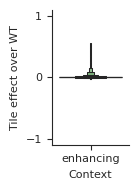

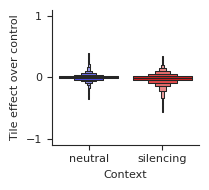

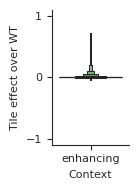

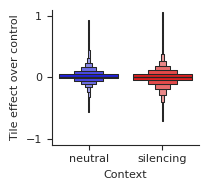

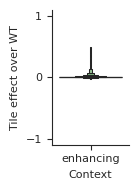

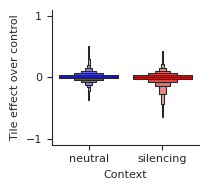

In [6]:
suf_result_summary = pd.read_csv('../results/summary_csvs/enformer/sufficiency_test.csv')
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
#sns.set(font_scale = .9)
sns.set_style(style='white')
#plt.rcParams['xtick.major.size'] = 5
#plt.rcParams['xtick.major.width'] = 1
#plt.rcParams['ytick.major.size'] = 5
#plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True


for c, (cell, df) in enumerate(suf_result_summary.groupby('cell_line')):

    enh_cont = df[df['context'] == 'enhancing']
    others = df[df['context'] != 'enhancing']
    sizes = [1.6, 2.3]
    filenames = ['enhancing', 'non-enhancing']
    yaxis_labels = ['Tile effect over WT', 'Tile effect over control']
    for p, (df_cont, y) in enumerate([[enh_cont, '(MUT - CONTROL) / WT'],
                                     [others, '(MUT - CONTROL) / CONTROL']]):
        fig, ax = plt.subplots(1, 1, figsize=[sizes[p], 2])

#         ax = axes[c, p]
        sns.boxenplot(x='context', y=y, data=df_cont, 
                      showfliers=False,
#                       hue='context',
                      ax=ax,
                      palette = my_pal)

        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=fontsize)
        ax.set_ylabel(yaxis_labels[p], fontsize=fontsize)
        ax.set_ylim(-1.1,1.1)
        
#         ax.legend(bbox_to_anchor=[1.3,1])
        #ax.set_title(f"{cell}")

        plt.tight_layout()
        fig.savefig(f'{pdf_dir}/enformer_{filenames[p]}_{cell}.pdf')


In [27]:
filenames[p]

'non-enhancing'

# Display number of CREs for distance test

In [28]:
selected_cres = pd.read_csv('../results/summary_csvs/enformer/sufficient_CREs.csv')
selected_cres.groupby(['cell_line', 'tile class', 'context']).count()

Unnamed: 0  (MUT - CONTROL) / WT  \
cell_line tile class context                                       
GM12878   Enhancer   enhancing          41                    41   
          Silencer   silencing          57                    57   
K562      Enhancer   enhancing          74                    74   
          Silencer   silencing         222                   222   
PC-3      Enhancer   enhancing          35                    35   
          Silencer   silencing          97                    97   

                                (MUT - CONTROL) / CONTROL  seq_id  control  \
cell_line tile class context                                                 
GM12878   Enhancer   enhancing                         41      41       41   
          Silencer   silencing                         57      57       57   
K562      Enhancer   enhancing                         74      74       74   
          Silencer   silencing                        222     222      222   
PC-3      Enhancer   enhancing                         35      35       35   
          Silencer   silencing                         97      97       97   

                                 wt  mut  tile_start  tile_end  \
cell_line tile class context                                     
GM12878   Enhancer   enhancing   41   41          41        41   
          Silencer   silencing   57   57          57        57   
K562      Enhancer   enhancing   74   74          74        74   
          Silencer   silencing  222  222         222       222   
PC-3      Enhancer   enhancing   35   35          35        35   
          Silencer   silencing   97   97          97        97   

                                Normalized CRE effect  
cell_line tile class context                           
GM12878   Enhancer   enhancing                     41  
          Silencer   silencing                     57  
K562      Enhancer   enhancing                     74  
          Silencer   silencing                    222  
PC-3      Enhancer   enhancing                     35  
          Silencer   silencing                     97

# Necessity VS Sufficiency

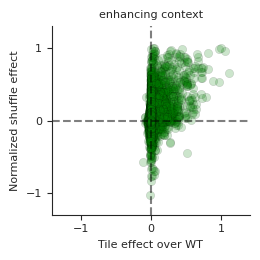

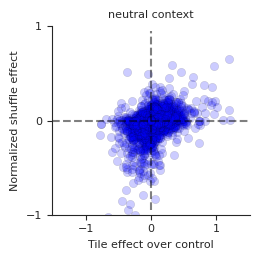

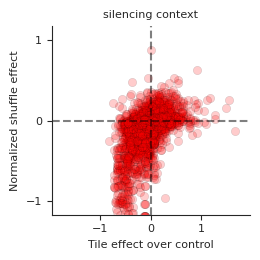

In [8]:
colors = ['g', 'b', 'r']
y = 'Normalized shuffle effect'
for i, c in enumerate(['enhancing', 'neutral', 'silencing']):
    fig, ax = plt.subplots(1, 1, figsize=[2.7, 2.7])

    if c == 'enhancing':
        x = '(MUT - CONTROL) / WT'
        xlabel = 'Tile effect over WT'
    else:
        x = '(MUT - CONTROL) / CONTROL'
        xlabel = 'Tile effect over control'

        
        
    merged_df = nec_result_summary[nec_result_summary['context'] == c].merge(suf_result_summary[suf_result_summary['context'] == c], on=['seq_id', 'tile_start'])
    x_max = merged_df[x].max()+0.3
    y_max = merged_df[y].max()+0.3
    sns.scatterplot(data=merged_df, x=x, y=y, color=colors[i], alpha=0.2, linewidth=0.3, edgecolor='k', ax=ax)
    ax.set_xlim(-x_max, x_max)
    ax.set_ylim(-y_max, y_max)
    ax.vlines(0, -y_max, y_max, linestyle='--', color='k', alpha=0.5)
    ax.hlines(0, -x_max, x_max, linestyle='--', color='k', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks([-1, 0, 1], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(y, fontsize=fontsize)
    ax.set_title(f'{c} context', fontsize=fontsize)
    plt.tight_layout()
    fig.savefig(f'{pdf_dir}/necessity_vs_sufficiency_scatterplot_{c}.png')